# Algoritmo de Viterbi para HMMs

Podemos entender un modelo oculto de Markov como la tupla: $$HMM = (\Sigma, S, A, \Pi, B)$$ donde $\Sigma$ es el alfabeto de observaciones, $S$ el alfabeto de emisiones, $(A, \Pi)$ un modelo del lenguaje sobre $S$ y, finalmente, $B$ la matriz de probabilidades de emisión.

Para construir este modelo necesitaremos diferentes librerías:

In [1]:
from collections import Counter, defaultdict
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.strip().split()]

La idea es encontrar una función que sea capaz de mapear cadenas en un lenguaje $L_1$ a un lenguaje $L_2$. En este sentido, el primer lenguaje es el español y el segundo corresponde a las cadenas de etiqeutas POS.

In [2]:
obs = ['el salto de altura', 'yo salto la cuerda', 
         'ellos tomaban vino', 'ellos saltaban la cuerda', 'ellos saltaban el salto',
      'yo salto']
ems = ['DA NC PP NC', 'DP V DA NC', 'DP V NC', 'DP V DA NC', 'DP V DA NC', 'DP V']

## Obtención de los vocabularios (alfabetos)

Ahora tenemos que indicar cuáles son las observaciones y cuáles los símbolos de emisión. Asimimso, asignaremos sus frecuencias y las probabilidades iniciales.

In [3]:
#Vocabulario de observaciones
obs_voc = vocab()
obs_cads = list(text2numba(obs,obs_voc))
print(obs_voc)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f5e8f3eb700>, {'el': 0, 'salto': 1, 'de': 2, 'altura': 3, 'yo': 4, 'la': 5, 'cuerda': 6, 'ellos': 7, 'tomaban': 8, 'vino': 9, 'saltaban': 10})


In [4]:
#Vocabulario de emisiones
ems_voc = vocab()
ems_cads = list(text2numba(ems,ems_voc))
print(ems_voc)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f5e8c35bc10>, {'DA': 0, 'NC': 1, 'PP': 2, 'DP': 3, 'V': 4})


Para obtener la matriz $B$ de probabilidades de emisión, requerimos saber que observaciones son generadas por qué emisiones. Para esto obtendremos pares de la forma $(o_i,s_j)$ con $o_i \in \Sigma$ y $s_j \in S)$. Esto es, si la observación $o_i$ está etiquetado con la emisión $s_i$ entonces lo tomaremos como un par de este conjunto.

In [5]:
#Pares de observaciones y sus etiquetas
obs_ems = list(chain(*[list(zip(c[0],c[1])) for c in zip(obs_cads,ems_cads)]))
print(obs_ems)

[(0, 0), (1, 1), (2, 2), (3, 1), (4, 3), (1, 4), (5, 0), (6, 1), (7, 3), (8, 4), (9, 1), (7, 3), (10, 4), (5, 0), (6, 1), (7, 3), (10, 4), (0, 0), (1, 1), (4, 3), (1, 4)]


In [6]:
#Obtención de las etiquetas
tags = {v:k for k,v in ems_voc.items()}

Asimismo, para crear el modelo del lenguaje sobre $S$ requerimos llenar la matriz $A$ y el vector $\Pi$, para esto, a cada cadena de símbolos de emisión se le agregan los símbolos de inicio (BOS) y final (BOS).

In [7]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(ems_voc.values())+2
EOS_IDX = max(ems_voc.values())+1

#Se agregan estas etiqeutas al vocabulario
ems_voc[EOS] = EOS_IDX
ems_voc[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
ems_cads = [[BOS_IDX] + cad + [EOS_IDX] for cad in ems_cads]

emsID = {v:k for k,v in ems_voc.items()}

print(ems_cads)

[[6, 0, 1, 2, 1, 5], [6, 3, 4, 0, 1, 5], [6, 3, 4, 1, 5], [6, 3, 4, 0, 1, 5], [6, 3, 4, 0, 1, 5], [6, 3, 4, 5]]


A partir de las cadenas de emisiones (que pertenencen a $S^*$) obtenemos los bigramas que se atestiguaron en el corpus.

In [8]:
#Bigramas a partir de las cadenas de emisiones
ems_bigrams = list(chain(*[ zip(cad,cad[1:]) for cad in ems_cads] ))
print(ems_bigrams)

[(6, 0), (0, 1), (1, 2), (2, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5), (6, 3), (3, 4), (4, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5), (6, 3), (3, 4), (4, 5)]


## Estimación del modelo oculto de Markov

Una vez obtenido los vocabularios, así como sus indices, así como los pares de observaciones y sus emisiones y los bigramas de emisiones, podemos determinar el modelo; es decir, estimaremos las probabilidades que llenarán las marices $A$, $\Pi$ y $B$.

In [9]:
#Longitud del vocabulario de emisiones
N = len(ems_voc)
#Longitud del vocabulario de observaciones
M = len(obs_voc)

#ems language model
Pi = np.zeros(N-2)
A = np.zeros((N-2,N-1))

#Prob ems
B = np.zeros((M,N-2))

Para obtener el modelo del lenguaje sobre $S$ estimaremos los siguientes elementos:
* La matriz de transiciones:

$$A=(a_{ij}) = p(s_j|s_i)  = \frac{\#(s_i s_j)+1}{\#(s_i) + N}$$

* El vector de iniciales:

$$\Pi = (\pi_{i}) = p(s_i) = \frac{\#(BOS, s_i)+1}{\#(BOS)+N}$$

In [10]:
#Frecuencia de bigramas de emisiones
frec_ems = Counter(ems_bigrams)

#Llenado de las frecuencias
for em, frec_em in frec_ems.items():
    if em[0] == BOS_IDX:
        Pi[em[1]] = frec_em
    else:
        A[em] = frec_em

In [11]:
#Sommothing
A = ((A.T+1)/(A+1).sum(1)).T
Pi = (Pi+1)/(Pi+1).sum(0)

pd.DataFrame(data=A, index=list(ems_voc.keys())[:-2], columns=list(ems_voc.keys())[:-1])

,DA,NC,PP,DP,V,<EOS>
DA,0.100000,0.500000,0.100000,0.100000,0.100000,0.100000
NC,0.083333,0.083333,0.166667,0.083333,0.083333,0.500000
PP,0.142857,0.285714,0.142857,0.142857,0.142857,0.142857
DP,0.090909,0.090909,0.090909,0.090909,0.545455,0.090909
V,0.363636,0.181818,0.090909,0.090909,0.090909,0.181818


In [12]:
pd.DataFrame(data=Pi, index=list(ems_voc.keys())[:-2], columns=['Init'])

,Init
DA,0.181818
NC,0.090909
PP,0.090909
DP,0.545455
V,0.090909


In [13]:
#Comprobar que las sumas sean 1
print(A.sum(1))
print(Pi.sum(0))

[1. 1. 1. 1. 1.]
1.0


Para obtener la matriz $B$, usaremos la siguiente función:

$$B = (b_{ij}) = p(o_j|s_i) = \frac{\#(o_j, s_i)+1}{\#(s_i)+M}$$

In [14]:
#Frecuencia de pares de observaciones y emisiones
frec_obs = Counter(obs_ems)

#Llenado con las frecuencias
for ob, frec_ob in frec_obs.items():
    B[ob] = frec_ob

In [15]:
#Smoothing
B = ((B+1).T/(B+1).sum(1)).T

pd.DataFrame(data=B, index=list(obs_voc.keys()), columns=list(ems_voc.keys())[:-2])

,DA,NC,PP,DP,V
el,0.428571,0.142857,0.142857,0.142857,0.142857
salto,0.111111,0.333333,0.111111,0.111111,0.333333
de,0.166667,0.166667,0.333333,0.166667,0.166667
altura,0.166667,0.333333,0.166667,0.166667,0.166667
yo,0.142857,0.142857,0.142857,0.428571,0.142857
la,0.428571,0.142857,0.142857,0.142857,0.142857
cuerda,0.142857,0.428571,0.142857,0.142857,0.142857
ellos,0.125000,0.125000,0.125000,0.500000,0.125000
tomaban,0.166667,0.166667,0.166667,0.166667,0.333333
vino,0.166667,0.333333,0.166667,0.166667,0.166667


In [16]:
#Comprobar que se sume 1
print(B.sum(1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Cálculo bruto de cadena de emisiones

Podemos preguntarnos cómo obtener el mejor etiquetado dado una secuencia de observaciones. Un primer caso es calcular la probabilidad de cada una de las posibles cadenas de emisiones y encontrar:

$$\arg\max p(s^{(1)},...,s^{(T)}, w^{(1)},...,w^{(T)})$$

Sin embargo, en este caso, tenemos que obtener todas las posibles convinaciones de $N$ símbolos de emisiones en $T$ elementos de la cadena. Es decir, tenemos que realizar $N^T$ cálculos, una complejidad exponencial.

In [17]:
from itertools import product

text1 = 'yo salto el salto de altura ellos saltaban'

candidatos = list(product( list(ems_voc.keys())[:-2], repeat=len(text1.split()) ))
print(len(candidatos))
print(candidatos[:5])

390625
[('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'NC'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'PP'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DP'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'V')]


In [18]:
%%time

#Función para el cálculo de probabilidades conjuntas p(s1,...,sT,w1,..,wT)
def prob_conj(text, tags):
    tags_bigrs = list(zip( tags.split(), tags.split()[1:] ))
    text_pairs = list(zip( text.split(), tags.split() ))
    p = Pi[ ems_voc[tags_bigrs[0][0]] ]
    
    for bi in tags_bigrs:
        p *= A[ ems_voc[bi[0]], ems_voc[bi[1]] ]
        
    for t in text_pairs:
        p *= B[ obs_voc[t[0]], ems_voc[t[1]] ]
    
    return p

#Guarda los candidatos
temp = np.zeros(len(candidatos))

#Obtiene la probabilidad para todos los candidatos
for i,cand in enumerate(candidatos):
    cand_tags = ' '.join(cand)
    temp[i] = prob_conj(text1, cand_tags )

#El candidato que maximiza la probabilidad
ArgMax = np.argmax(temp)

print(text1)
print(candidatos[ArgMax])

yo salto el salto de altura ellos saltaban
('DP', 'V', 'DA', 'NC', 'PP', 'NC', 'DP', 'V')
CPU times: user 6.86 s, sys: 454 µs, total: 6.86 s
Wall time: 6.86 s


## Aplicación del algoritmo de Viterbi

El algoritmo de Viterbi nos permitirá obtener las emisiones que maximicen la probabilidad conjunta con las observaciones. Podemos observar que las posibles combinaciones de observaciones son $N^T$ donde $N$ es el número de símbolos de emisión y $T$ la longitud de la observación.

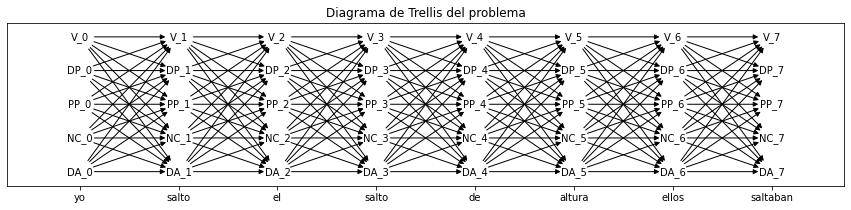

In [19]:
#Aristas
edges = []
#Posiciones
layout_all = {}
for t,w in enumerate(text1.split()):
    #Obtienes las aristas del diagrama Trellis
    for s in list(ems_voc.keys())[:-2]:
        for st in list(ems_voc.keys())[:-2]:
            prev = s+'_'+str(t)
            actual = st+'_'+str(t+1)
            layout_all[prev] = np.array([t, ems_voc[s]])
            if t < len(text1.split()) - 1:
                edges.append( (prev, actual) )
                layout_all[actual] = np.array([t+1, ems_voc[s]])
        

#Gráfica del diagrama
graph = nx.DiGraph()
graph.add_edges_from(edges)

#Visualización
fig, ax = plt.subplots(figsize=(15, 3))
nx.draw_networkx(graph, with_labels=True, node_size=700, font_size=10, node_color='#ffffff', pos=layout_all, ax=ax)
ax.tick_params(bottom=True, labelbottom=True)
plt.title('Diagrama de Trellis del problema')
plt.xticks([0,1,2,3,4,5,6,7], text1.split())
plt.show()

### Forward

En primer lugar obtenemos las variables $\delta_j(t)$ para todo símbolo y para todo estado $t$. Estas variables, junto con las variables $\phi_j(t)$ nos darán los posibles caminos con mayor probabilidad dentro de la gráfica Trellis.

En primer lugar tomamos la observación y generamos un estado por cada uno de los elementos en la cadena de observaciones.

Asimismo, iniciamos las variables $\delta$ y $\phi$, tal que:

$$\delta_j(t) = \max_{i_1,...,i_{t-1}} p(s_{i_1}^{(1)},..., s_{i_{t-1}}^{(t-1)}, w^{(1)},...,w^{(t)}, s^{(t)}_j)$$

y:

$$\phi_j(t) = \arg\max_{i_1,...,i_{t-1}} p(s_{i_1}^{(1)},..., s_{i_{t-1}}^{(t-1)}, w^{(1)},...,w^{(t)}, s^{(t)}_j)$$



In [20]:
#Obtenemos las observaciones por estado
obs_text = text1.split()

#Variable delta guarda las probs máximas
d = np.zeros((len(obs_text),len(ems_voc)-2))
#Variable phi guarda los argumentos que maximizan las probs
phi = np.zeros((len(obs_text),len(ems_voc)-2))

El algoritmo de Viterbo se definirá como:

* <b>Inicialización</b>: $$\delta_j(1) = p(w^{(1)}|s_j)p(s_j)$$ o bien, en términos de matrices $$\delta(1) = B_{w^{(1)}} \odot Pi$$
* <b>Inducción</b>: $$\delta_j(t+1) = \max_i p(w^{(t+1)}|s_j)p(s_j|s_i)\delta_i(t)$$ o en términos de vectores y matrices: $$\delta(t+1) = \max_i A \odot \Big(B_{w^{(t+1)}} \otimes \delta(t) \Big)$$ Las variables $\phi$ se calculan de forma similar pero usando el $\arg\max$.

In [21]:
%%time
#Inicialización
d[0] = B[ obs_voc[obs_text[0]] ]*Pi

#Inducción
for t in range(0, len(obs_text)-1):
    #Calculamos las probabilidades
    probs = A[:,:-1]*np.outer(B[obs_voc[obs_text[t]]], d[t])
    
    #Obtenemos las variables delta
    d[t+1] = np.max(probs,axis=0)
    #Obtenemos variables phi
    phi[t] = np.argmax(probs,axis=0)

pd.DataFrame(data=d, index=obs_text, columns=list(ems_voc.keys())[:-2])

CPU times: user 1.67 ms, sys: 0 ns, total: 1.67 ms
Wall time: 1.48 ms


,DA,NC,PP,DP,V
yo,2.597403e-02,1.298701e-02,1.298701e-02,2.337662e-01,1.298701e-02
salto,1.349300e-03,9.276438e-04,5.059875e-04,9.107775e-03,3.035925e-03
el,1.635515e-04,5.622084e-05,2.811042e-05,2.759932e-04,1.839955e-04
salto,8.496183e-06,1.204732e-05,1.204732e-06,1.182828e-05,1.433731e-05
de,1.029840e-06,7.301407e-07,6.692957e-08,3.584327e-07,8.689278e-07
altura,6.241457e-08,6.953721e-08,3.187122e-09,1.706822e-08,7.899344e-08
ellos,3.782701e-09,5.794768e-09,1.770623e-10,4.741174e-10,7.181221e-09
saltaban,1.719410e-10,3.621730e-10,8.048288e-12,2.155079e-11,1.958515e-09


Podemos visualizar también las etiquetas que ha guardado la variable $\phi$.

In [22]:
phi_cat = []
for j, c in enumerate(phi):
    phi_cat.append([tags[i] for i in c])
    
pd.DataFrame(data=phi_cat, index=obs_text, columns=list(ems_voc.keys())[:-2])

,DA,NC,PP,DP,V
yo,V,DA,DP,DP,DP
salto,V,V,NC,V,DP
el,V,DA,DA,DA,DP
salto,V,V,NC,V,DP
de,V,PP,PP,PP,DP
altura,V,DA,NC,NC,DP
ellos,DP,DA,DP,DP,DP
saltaban,DA,DA,DA,DA,DA


Lo que esta parte del algoritmo ha hecho es crear una gráfica con $N$ caminos, tantos como símbolos de emisión. De esta forma, la complejidad de la búsqueda se simplifica. Podemos observar cómo se comportan los caminos encontrados.

In [23]:
trellis = []
#Creamos las transiciones que se dan con Viterbi
for i, w in enumerate(obs_text):
    print(w)
    for s,j in ems_voc.items():
        try:
            if i != len(obs_text)-1:
                print('\t', phi_cat[i][j], '-->', s, d[i][j])
                trellis.append((phi_cat[i][j]+'_'+str(i), s+'_'+str(i+1), d[i][j]))
            else:
                print('\t', s, d[i][j],)
        except:
            pass

yo
	 V --> DA 0.025974025974025972
	 DA --> NC 0.012987012987012986
	 DP --> PP 0.012987012987012986
	 DP --> DP 0.23376623376623373
	 DP --> V 0.012987012987012986
salto
	 V --> DA 0.0013493000505987519
	 V --> NC 0.0009276437847866418
	 NC --> PP 0.0005059875189745319
	 V --> DP 0.009107775341541575
	 DP --> V 0.003035925113847191
el
	 V --> DA 0.0001635515212846972
	 DA --> NC 5.622083544161466e-05
	 DA --> PP 2.8110417720807326e-05
	 DA --> DP 0.00027599319216792647
	 DP --> V 0.00018399546144528428
salto
	 V --> DA 8.496182923880373e-06
	 V --> NC 1.2047321880345997e-05
	 NC --> PP 1.2047321880345996e-06
	 V --> DP 1.1828279664339705e-05
	 DP --> V 1.4337308684048124e-05
de
	 V --> DA 1.0298403544097422e-06
	 PP --> NC 7.301407200209695e-07
	 PP --> PP 6.692956600192219e-08
	 PP --> DP 3.5843271710120315e-07
	 DP --> V 8.689277990332196e-07
altura
	 V --> DA 6.241456693392376e-08
	 DA --> NC 6.95372114305685e-08
	 NC --> PP 3.187122190567723e-09
	 NC --> DP 1.7068224623866814e-08


Una forma más clara de verlo es a partir del diagrama de caminos que resultan de aplicar el algoritmo de Viterbi. Tenemos tantos caminos como símbolos. Sólo basta escoger un camino que máximice la probabilidad para obtener la cadena de emisiones más óptima.

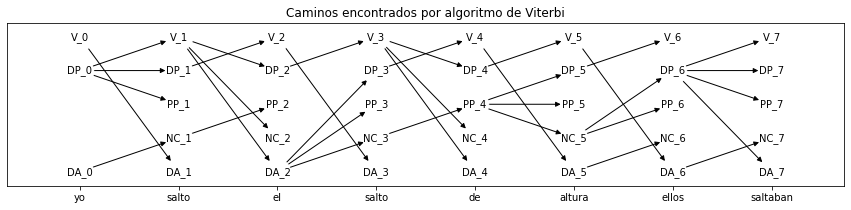

In [24]:
#Crea el diagrama Trellis
Trell = nx.DiGraph()
Trell.add_weighted_edges_from(trellis)

#Posiciona los nodos
layout = {}
for n in Trell.nodes:
    lab, t = n.split('_')
    layout[n] = np.array([float(t), ems_voc[lab]])

#Visalización
fig, ax = plt.subplots(figsize=(15, 3))
nx.draw_networkx(Trell, with_labels=True, node_size=700, font_size=10, node_color='#ffffff', pos=layout, ax=ax)
ax.tick_params(bottom=True, labelbottom=True)
plt.title('Caminos encontrados por algoritmo de Viterbi')
plt.xticks([0,1,2,3,4,5,6,7], obs_text)
plt.show()

### Backward

Para finalizar con el algoritmo de Viterbi, obtendremos el símbolo final que maximice la probabilidad. Inicializando como:

$$\hat{s}^{(T)} = \arg\max_i \delta_i(T)$$

Y con esto podemos recuperar el camino haciendo inducción sobre la variable $\phi$:

$$\hat{s}^{(t)} = \phi_{\hat{s}^{(t+1)}}(t+1)$$

In [25]:
#Inicialización
sT = np.argmax( d[len(obs_text)-1])

#Guarda las etiquetas
tags_prop = [sT]
for t in range(0, len(obs_text)-1)[::-1]:
    #Inducción
    st = int(phi[t][tags_prop[-1]])
    tags_prop.append(st)
        
print('Texto orig:',text1)
print('Viterbi:', [tags[w] for w in tags_prop][::-1])

Texto orig: yo salto el salto de altura ellos saltaban
Viterbi: ['DP', 'V', 'DA', 'NC', 'PP', 'NC', 'DP', 'V']
